In [9]:
from pathlib import Path
from datetime import datetime
import fiona
import numpy as np
from distributed import Client, performance_report

cwd = Path.cwd()
out_dir = cwd.joinpath('results', 's1_ratio_db_median')
vec = cwd.joinpath('vec', 'malalane.geojson')
now = datetime.now().strftime('%Y%m%dT%H%M')

n_workers = 1
threads_per_worker = 20
mem_limit = "50GB"

dask_client = Client(processes=False, n_workers=n_workers, threads_per_worker=threads_per_worker, memory_limit=mem_limit)

In [10]:
product = 's1_rtc'
measurements = ('vh', 'vv')

time_range = ('2019-01-01', '2020-12-31')
bbox = fiona.open(vec, 'r').bounds
x = (bbox[0], bbox[2])
y = (bbox[1], bbox[3])
output_crs = 'EPSG:4326'
resolution = (-0.0002, 0.0002)
resampling = 'bilinear'

dask_chunks = {'time': 1, 'latitude': 256, 'longitude': 256}
dask_rechunk = {'time': -1}

# 1. EO3 metadata - local - datacube-core

Not applicable on this system.

# 2. STAC metadata - local
Not applicable on this system.

# 3. STAC metadata - remote - odc-stac

[3] https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-S2-deafrica.html

In [11]:
from odc.stac import configure_rio
import pystac_client

configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com", client=dask_client)
remote_catalog = pystac_client.Client.open("https://explorer.digitalearth.africa/stac")
items = remote_catalog.search(bbox=bbox, collections=[product], datetime=f"{time_range[0]}/{time_range[1]}", max_items=None).get_all_items()

In [12]:
%%time
from odc.stac import load as stac_load

data_odcstac_remote = stac_load(items, bands=measurements, bbox=bbox, crs=output_crs, resolution=resolution[1],
                                resampling=resampling, chunks=dask_chunks)
data_odcstac_remote['ratio_db'] = 10 * np.log10(data_odcstac_remote.vh / data_odcstac_remote.vv)
data_odcstac_remote = data_odcstac_remote.chunk(chunks=dask_rechunk)

with performance_report(filename=out_dir.joinpath(f"{now}_{vec.stem}_stac-remote-odcstac_{n_workers}-{threads_per_worker}-{mem_limit}.html")):
    result_odcstac_remote = data_odcstac_remote.ratio_db.median(dim='time', skipna=True).compute()

/Users/marcowo/micromamba/envs/stac-access/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 6min 55s, sys: 1min 56s, total: 8min 51s
Wall time: 17min 41s


In [13]:
data_odcstac_remote.ratio_db

<xarray.DataArray 'ratio_db' (time: 169, latitude: 777, longitude: 1188)>
dask.array<rechunk-merge, shape=(169, 777, 1188), dtype=float32, chunksize=(169, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 -25.38 -25.38 -25.38 ... -25.54 -25.54
  * longitude    (longitude) float64 31.4 31.4 31.4 31.4 ... 31.63 31.63 31.63
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2019-01-06T03:18:46.924630 ... 2020-12...

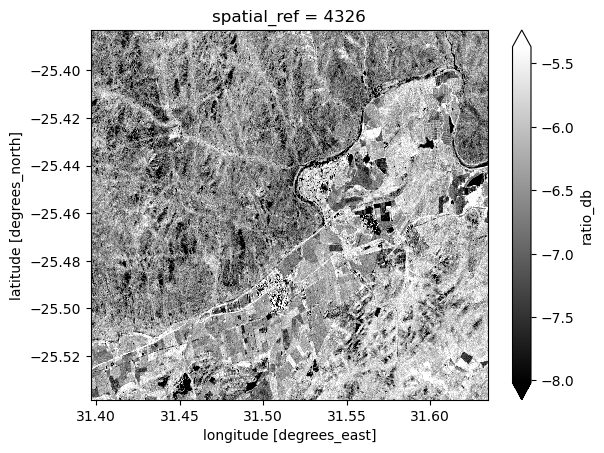

In [14]:
result_odcstac_remote.plot(robust=True, cmap='gray')

-----

## Additional information

In [15]:
import datacube
import odc.stac
import odc.geo
import stackstac
import rasterio
import pystac
import pystac_client
print(f"datacube=={datacube.__version__}")
print(f"odc.stac=={odc.stac.__version__}")
print(f"odc.geo=={odc.geo.__version__}")
print(f"stackstac=={stackstac.__version__}")
print(f"rasterio=={rasterio.__version__}")
print(f"pystac=={pystac.__version__}")
print(f"pystac_client=={pystac_client.__version__}")

datacube==1.8.12
odc.stac==0.3.5
odc.geo==0.3.3
stackstac==0.4.3
rasterio==1.3.6
pystac==1.7.3
pystac_client==0.6.1


In [16]:
!system_profiler SPSoftwareDataType SPHardwareDataType | grep -E "System Version|Model Name|Chip|Cores|Memory"

      System Version: macOS 13.3.1 (a) (22E772610a)
      Secure Virtual Memory: Enabled
      Model Name: MacBook Pro
      Chip: Apple M1 Max
      Total Number of Cores: 10 (8 performance and 2 efficiency)
      Memory: 64 GB


Librespeed:
- Download 287 Mbps
- Upload 56.8 Mbps
- Ping 39 ms